To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + support us if you can!
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

In [1]:
# %%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
# if major_version >= 8:
#     # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
#     !pip install "unsloth[colab_ampere] @ git+https://github.com/unslothai/unsloth.git"
# else:
#     # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
#     !pip install "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"
# pass
major_version

8

* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 3072 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
# load_in_4bit = False


# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.1-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "mistralai/Mistral-7B-v0.1", load_in_4bit = False,
    # model_name = "unsloth/mistral-7b-bnb-4bit", load_in_4bit = True,
    model_name = "unsloth/llama-2-7b-bnb-4bit", load_in_4bit = True,
    # model_name = "unsloth/tinyllama-bnb-4bit", load_in_4bit = True,
    max_seq_length = max_seq_length,
    dtype = dtype
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.2
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.999 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.24. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` attribute will be overwritten with the one you passed to `from_pretrained`.


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
from peft import LoftQConfig
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    # loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)

Unsloth 2024.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

In [4]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

import os
cwd = os.getcwd()
kaggle = cwd == "/kaggle/working"
data_dir = "/kaggle/input/masterthesis/" if kaggle else cwd+"/data/"

dataset_csv = pd.read_csv(data_dir + "dataset.csv")
from sklearn.model_selection import train_test_split
train, val = train_test_split(dataset_csv, test_size=0.2, random_state=42)
train.to_csv(data_dir + "train/train.csv", index=False)

In [5]:
train.sample(1)

,input,output
11,Date: 2021-09\nTopic: POWER CONTROL OF ASIC MI...,"[\n {\n ""hardware_name"": ""antminer S..."


In [6]:
prompt = """
User:
In the given Bitcoin forum thread, pay close attention to the language used when mentioning hardware pieces. Look for explicit statements indicating ownership or hypothetical discussions.

{}

Reply with a formatted JSON document containing an array of objects. Each object should represent a piece of hardware mentioned in the thread and include the following fields:
- hardware_name: A string containing the name of the hardware.
- hardware_is_owned: A boolean. If the mention suggests concrete ownership by any user, write true. If the hardware is discussed in a hypothetical or speculative way, write false. 


Assistant:
Sure! Here is the requested JSON file, with the correct ownership status for each piece of hardware:

```json
{}
```
""".strip()

dataset = load_dataset(data_dir+"train",data_files="train.csv", split="train")
def formatting_prompts_func(examples):
    output_texts = []
    for i in range(len(examples['input'])):
        text = prompt.format(examples['input'][i], examples['output'][i])+tokenizer.eos_token
        if i == 0:
            print(text)
            print(len(tokenizer.encode(text)))
        output_texts.append(text)
    return output_texts

response_template = "with the correct ownership status for each piece of hardware:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)



Generating train split: 0 examples [00:00, ? examples/s]

(array([ 6., 10.,  8.,  6.,  3.,  3.,  4.,  3.,  2.,  5.,  5.,  4.,  3.,
         2.,  2.]),
 array([ 269. ,  412.4,  555.8,  699.2,  842.6,  986. , 1129.4, 1272.8,
        1416.2, 1559.6, 1703. , 1846.4, 1989.8, 2133.2, 2276.6, 2420. ]),
 <BarContainer object of 15 artists>)

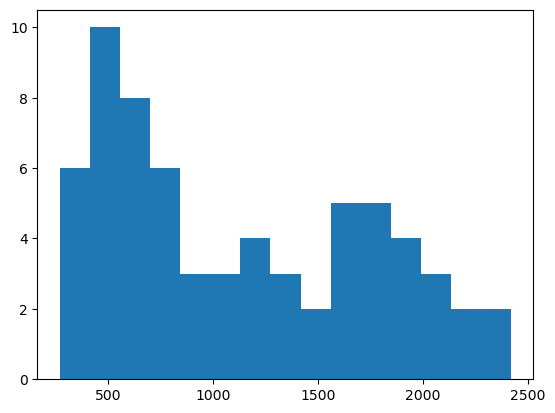

In [7]:
token_counts = []
for row in dataset_csv.iterrows():
    token_counts.append(len(tokenizer.encode(prompt.format(row[1]["input"], row[1]["output"])))
)
# plot the token counts
import matplotlib.pyplot as plt
plt.hist(token_counts, bins=15)

In [8]:
# train

In [9]:
# dataset

In [10]:
# formatting_prompts_func(dataset['train'])
dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 52
})

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [11]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    # dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

Map (num_proc=2):   0%|          | 0/52 [00:00<?, ? examples/s]

User:
In the given Bitcoin forum thread, pay close attention to the language used when mentioning hardware pieces. Look for explicit statements indicating ownership or hypothetical discussions.

Date: 2017-12
Topic: DIY S1 to S3 adapter-board
### Original post:
As many of you know I managed to make a working adapter-board to convert S1 controller work with S3 blades.I have now drawn PCB for it and actually ordered a little batch of these boards made by factory.Many of you can make your own adapter with information given in this thread: <link> I wonder if there is anyone interested in ready made boards?And if so, do you want just plain PCB or whole board fully populated and with connectors? I'm asking this because I'll order connectors and regulators more if needed.Pictures here are of my home-made PCB but factory-made will be double sided.So there are no jumper wires.But lay-out of the board is pretty much the same as in pics here.Adapter board: I'll have PCB's after 2-3 weeks and so t

In [12]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3090. Max memory = 23.999 GB.
4.121 GB of memory reserved.


In [13]:
trainer_stats = trainer.train()

Step,Training Loss
1,0.224900
2,0.213100
3,0.174600
4,0.148700
5,0.132000
6,0.136500


In [14]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

69.6997 seconds used for training.
1.16 minutes used for training.
Peak reserved memory = 8.203 GB.
Peak reserved memory for training = 4.082 GB.
Peak reserved memory % of max memory = 34.181 %.
Peak reserved memory for training % of max memory = 17.009 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [15]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [16]:
# example = dev
# test_str = prompt.format(example['text'][0], "")
# print(test_str)

In [17]:
val.iloc[0]['input']

"Date: 2018-02\nTopic: Electricity Setup for Miners (240v)\n### Original post:\nI'm also interested in this. I have a few questions that I'd like to tack on.I'm hoping to run two AntMiner S9s with either AWP5s or AWP3++s to power them. Along with figuring our what receptacle should be installed, I also want to know what amperage the line should be rated for. Do I need a dedicated circuit for each power supply?Are there recommendations on which PSU to use?Edit: I'm in Ontario, Canada, if that makes a difference.\n\n### Reply 1:\nGive them each their own 10 amp circuit or a single circuit with 20 amps and you will be fine for 2.The s9 draws around 7 amps max on 220v power. The receptacle doesnt really matter since you can buy any kind of power cable to go from your power supply to the socket.\n\n### Reply 2:\nThank you. i had the electrician come out today. Im going to be running power to my shed, so when i dig the trench im going to run the internet out there as well. Now i need to figu

In [18]:
input_strings = []
input_labels = []
for i in range(len(val['input'])):
    test_str = prompt.format(val.iloc[i]['input'], "").split("```json")[0]+"```json"
    input_strings.append(test_str)
    input_labels.append(val.iloc[i]['output'])
    # print(i)




In [19]:
total = 0

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

for i in range(len(input_strings)):
    s = input_strings[i]
    # print(f"{i}: {s}")
    inputs = tokenizer([s], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 300, use_cache = True)
    output = tokenizer.batch_decode(outputs)
    
    print("Input:", s, "\n\n\n\n")
    print("Output:", output[0].replace(s,""), "\n\n\n\n")
    print("Label:", input_labels[i], "\n\n\n\n")
    print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")


    total += 1
    # if total > 10:
    break

# print(f"Correct: {correct} Total: {total} Accuracy: {correct/total}")

Input: User:
In the given Bitcoin forum thread, pay close attention to the language used when mentioning hardware pieces. Look for explicit statements indicating ownership or hypothetical discussions.

Date: 2018-02
Topic: Electricity Setup for Miners (240v)
### Original post:
I'm also interested in this. I have a few questions that I'd like to tack on.I'm hoping to run two AntMiner S9s with either AWP5s or AWP3++s to power them. Along with figuring our what receptacle should be installed, I also want to know what amperage the line should be rated for. Do I need a dedicated circuit for each power supply?Are there recommendations on which PSU to use?Edit: I'm in Ontario, Canada, if that makes a difference.

### Reply 1:
Give them each their own 10 amp circuit or a single circuit with 20 amps and you will be fine for 2.The s9 draws around 7 amps max on 220v power. The receptacle doesnt really matter since you can buy any kind of power cable to go from your power supply to the socket.

##

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [20]:
# # alpaca_prompt = Copied from above
# FastLanguageModel.for_inference(model) # Enable native 2x faster inference
# inputs = tokenizer(
# [
#     alpaca_prompt.format(
#         "Continue the fibonnaci sequence.", # instruction
#         "1, 1, 2, 3, 5, 8", # input
#         "", # output - leave this blank for generation!
#     )
# ], return_tensors = "pt").to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [21]:
# model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [22]:
# if False:
#     from unsloth import FastLanguageModel
#     model, tokenizer = FastLanguageModel.from_pretrained(
#         model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
#         max_seq_length = max_seq_length,
#         dtype = dtype,
#         load_in_4bit = load_in_4bit,
#     )
#     FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# # alpaca_prompt = You MUST copy from above!

# inputs = tokenizer(
# [
#     alpaca_prompt.format(
#         "What is a famous tall tower in Paris?", # instruction
#         "", # input
#         "", # output - leave this blank for generation!
#     )
# ], return_tensors = "pt").to("cuda")

# outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
# tokenizer.batch_decode(outputs)

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [23]:
# if False:
#     # I highly do NOT suggest - use Unsloth if possible
#     from peft import AutoModelForPeftCausalLM
#     from transformers import AutoTokenizer
#     model = AutoModelForPeftCausalLM.from_pretrained(
#         "lora_model", # YOUR MODEL YOU USED FOR TRAINING
#         load_in_4bit = load_in_4bit,
#     )
#     tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [24]:
# Merge to 16bit
# model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit_forced",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...


AttributeError: 'LlamaForCausalLM' object has no attribute 'merge_and_unload'

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Llama 7b [free Kaggle](https://www.kaggle.com/danielhanchen/unsloth-alpaca-t4-ddp)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>